# Creating UBWO3 guidance 

Steps:
* Download HRRR data for each hour 
* 

In [1]:
import warnings

import pandas as pd
import xarray
import numpy as np
import metpy 
from cartopy import crs as ccrs
import matplotlib as M
import matplotlib.pyplot as plt 

from herbie import Herbie

# Use for "operations" 
warnings.filterwarnings(action='ignore')

In [48]:
def setup_herbie(inittime, fxx=0, product="nat", model="hrrr"):
    H = Herbie(
    inittime,
    model=model,
    product=product,
    fxx=fxx,
    )
    return H
    
def get_CONUS(qstr,herbie_inst):
    ds = herbie_inst.xarray(qstr, remove_grib=False)
    variables = [i for i in list(ds) if len(ds[i].dims) > 0]
    ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()
    return ds 

def get_closest_point(ds,vrbl,lat,lon):
    grid_crs = ds[vrbl].metpy.cartopy_crs
    latlon_crs = ccrs.PlateCarree(globe=ds[vrbl].metpy.cartopy_globe)
    x_t, y_t = grid_crs.transform_point(lon, lat, src_crs=latlon_crs)
    pass
    return ds[vrbl].sel(x=x_t,y=y_t,method="nearest")

def crop_to_UB(ds,):
    # ds = ds.rename({'x':'west_east','y':'south_north'})

    sw_corner = (39.4, -110.9)
    ne_corner = (41.1, -108.5)
    lats = ds.latitude.values
    lons = ds.longitude.values
    
    if np.max(lons) > 180.0: 
        lons -= 360.0
    
    crop = xarray.DataArray(np.logical_and(np.logical_and(lats>sw_corner[0],
                         lats<ne_corner[0]),np.logical_and(lons>sw_corner[1],lons<ne_corner[1])),
                        # dims=['south_north','west_east'])
                            dims = ['y','x'])
    return ds.where(crop,drop=True)

def do_sfc_plot(ds,vrbl,minmax=None):
    # TODO: units and conversion elegantly!
    data = ds[vrbl]
    if vrbl == "t2m":
        # K to C
        data -= 273.15
    fig,ax = plt.subplots(1)
    if minmax is None:
        im = ax.imshow(data[::-1,:])
    else:
        im = ax.imshow(data[::-1,:],vmin=minmax[0],vmax=minmax[1])
    plt.colorbar(im)
    return fig,ax
    
def make_query_string(vrbl):
    pass 

def do_model_sounding(T_profile, Z_profile, xlim=None, ylim=None):
    fig,ax = plt.subplots(1)
    ax.plot(T_profile, Z_profile)
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    return fig,ax

# Dictionary for variable names?

In [3]:
inittime = "2023-02-06 23:00"
fxx = 1
H = setup_herbie(inittime, fxx=fxx)


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Feb-06 23:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws


In [4]:
q_t2m = ":TMP:2 m"
ds_t2m = get_CONUS(q_t2m, H)
ds_t2m_crop = crop_to_UB(ds_t2m)

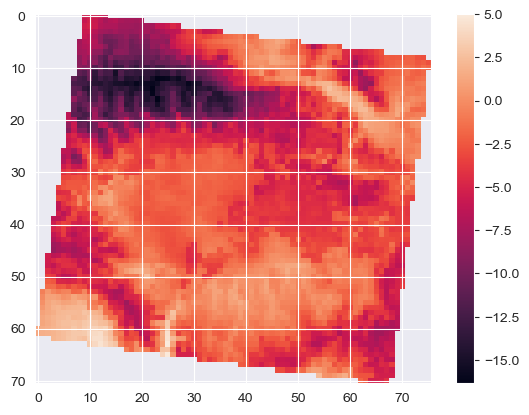

In [5]:
fig,ax = do_sfc_plot(ds_t2m_crop,"t2m")

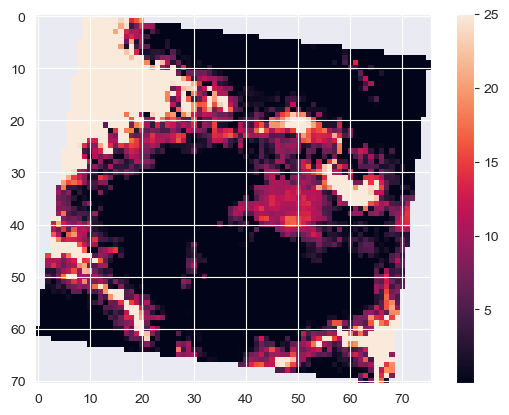

In [24]:
q_snod = ":SNOD:"
ds_snod = get_CONUS(q_snod, H)
ds_snod_crop = crop_to_UB(ds_snod)
fig,ax = do_sfc_plot(ds_snod_crop*100,"sde",minmax=(0.01,25))

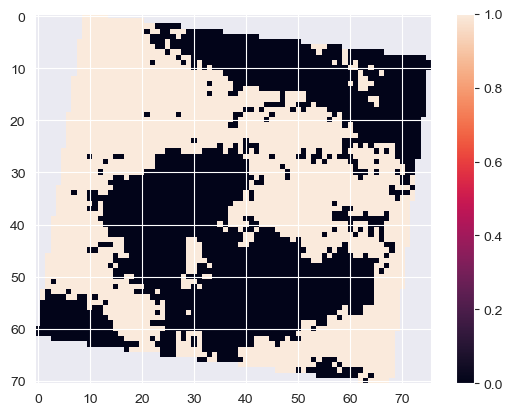

In [23]:
q_snowc = ":SNOWC:"
ds_snowc = get_CONUS(q_snowc, H)
ds_snowc_crop = crop_to_UB(ds_snowc)
# ds_snowc_crop
fig,ax = do_sfc_plot(ds_snowc_crop,"snowc",minmax=(0,1))

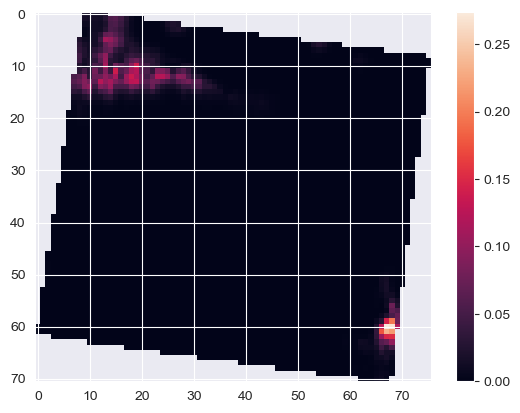

In [40]:
q_asnow = ":ASNOW:"
ds_asnow = get_CONUS(q_asnow, H)
ds_asnow_crop = crop_to_UB(ds_asnow)
ds_asnow_crop = ds_asnow_crop.rename({'unknown' : 'asnow',})
# ds_asnow_crop
fig,ax = do_sfc_plot(ds_asnow_crop*100,"asnow")

In [39]:
# Snow depth 
lat = 40.36435
lon = -109.34574
x = get_closest_point(ds_snod_crop,"sde",lat,lon)
print(f"{x.data*100:.1f} cm")

9.9 cm


In [7]:
q_Z = ':HGT:.*hybrid'
ds_Z = get_CONUS(q_Z, H)
ds_Z_crop = crop_to_UB(ds_Z)

In [8]:
q_T = ':TMP:.*hybrid'
ds_T = get_CONUS(q_T, H)
ds_T_crop = crop_to_UB(ds_T)

In [9]:
ds_Z_crop

<xarray.Dataset>
Dimensions:     (hybrid: 50, y: 71, x: 76)
Coordinates:
    time        datetime64[ns] 2023-02-06T23:00:00
    step        timedelta64[ns] 01:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 47.0 48.0 49.0 50.0
    latitude    (y, x) float64 39.18 39.18 39.19 39.19 ... 41.31 41.31 41.32
    longitude   (y, x) float64 -110.8 -110.8 -110.8 ... -108.6 -108.6 -108.5
    valid_time  datetime64[ns] 2023-02-07
    metpy_crs   object Projection: lambert_conformal_conic
  * y           (y) float64 1.587e+05 1.617e+05 ... 3.657e+05 3.687e+05
  * x           (x) float64 -1.147e+06 -1.144e+06 ... -9.245e+05 -9.215e+05
Data variables:
    gh          (hybrid, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 nat
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/johnlawson/data/hrrr/20230206/subset_e1e4...
    searchString:            :HGT:.*hybrid

In [10]:
q_P = ":PRES:.*hybrid"
ds_P = get_CONUS(q_P, H)
ds_P_crop = crop_to_UB(ds_P)

-2.473816


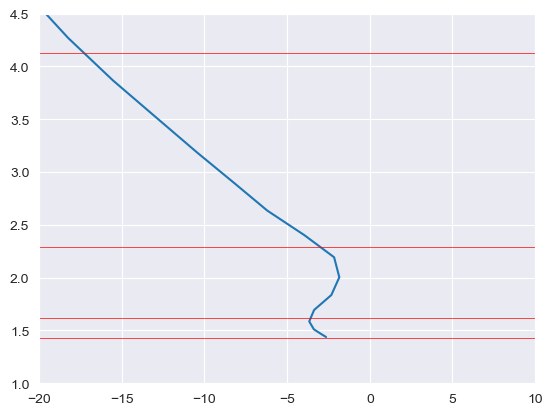

In [11]:
# Do a model sounding
# Vernal
# lon, lat = (360-109.5287, 40.4555)

# Ouray 40.0891° N, 109.6774° W
lon, lat = (360-109.6774, 40.0891)

x = get_closest_point(ds_t2m_crop,"t2m",lat,lon)
print(x.data)

# Label altitudes 
T_prof = get_closest_point(ds_T_crop,"t",lat,lon) - 273.15 # Celsius
Z_prof = get_closest_point(ds_Z_crop,"gh",lat,lon) / 1000 # km
fig,ax = do_model_sounding(T_prof,Z_prof,xlim=[-20,10],ylim=[1.0,4.5])

# Ouray
plt.axhline(1.425,color='red',lw=0.5)

# Vernal
plt.axhline(1.622,color='red',lw=0.5)

# Split Mtn
plt.axhline(2.294,color='red',lw=0.5)

# Kings Peak
plt.axhline(4.123,color='red',lw=0.5)

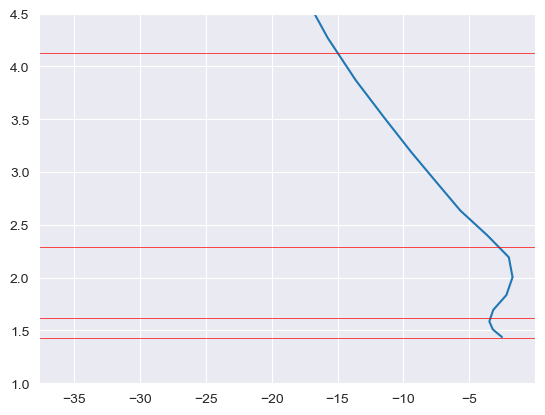

In [12]:
P_prof = get_closest_point(ds_P_crop,"pres",lat,lon) 

# Constants
P0 = 100000 
Rd = 287  # J/kg·K
Cp = 1005  # J/kg·K

# def calculate_dry_bulb_temperature(potential_temperature, pressure):
#     return potential_temperature * (pressure / P0) ** (Rd / Cp)

theta_prof = T_prof * (P_prof/P0)**(Rd/Cp)
fig,ax = do_model_sounding(theta_prof,Z_prof,ylim=[1.0,4.5])

plt.axhline(1.425,color='red',lw=0.5)
plt.axhline(1.622,color='red',lw=0.5)
plt.axhline(2.294,color='red',lw=0.5)
plt.axhline(4.123,color='red',lw=0.5)

✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F18 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F21 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F27 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F30 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr 

TypeError: 'Text' object is not callable

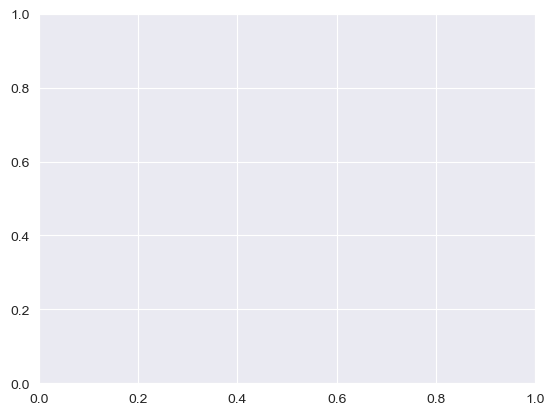

In [22]:
# Do a meteogram of t2m by looping over times
# fxx = list(range(0,11))
# fxx = [6,12,18,24,30]
lat = 40.4414337
lon = -109.5667656
fxx = list(range(0,49,3))
# timeseries = []
inittime = "2023-11-23 12:00"
q_snow = ":SNOD:"
q_vwind = ":VGRD:10 m"
q_t2m = ":TMP:2 m"
# q_allsfc = ":surface:"
q_vars = {q_snow:[], q_vwind:[], q_t2m:[]}
key_lookup = {q_snow:"sde",q_vwind:"v10", q_t2m:"t2m"}

for f in fxx:
    H2 = setup_herbie(inittime, fxx=f, product="nat", model="hrrr")
    for qv, timeseries in q_vars.items():
        ds = get_CONUS(qv, H2)
        ds_crop = crop_to_UB(ds)  
        val = get_closest_point(ds_crop,key_lookup[qv],lat,lon)
        if qv == q_t2m:
            val -= 273.15
        
        # print(val)
        # Here is where to grab all desired variables for this time 
        # Could query all variables together (for hybrid levels, one level, etc)
        timeseries.append(val)
    
for qv,timeseries in q_vars.items():
    fig,ax = plt.subplots(1)
    ax.set_title(key_lookup[qv])
    ax.plot(fxx,timeseries)
    ax.axhline(0,color="red",linewidth=0.5)
    # ax.set_xticks(fxx,np.array(fxx)-7)


In [49]:
# Do a meteogram of t2m by looping over times
# fxx = list(range(0,11))
# fxx = [6,12,18,24,30]
import pandas as pd 
lat = 40.4414337
lon = -109.5667656

varname_lookup = {
                    "Accum snowfall (m)":"acsno",
                    "Temperature (K)":"t",
                    # "Pressure (Pa)":"sp",
                    # "PBL height (m)":"blh",
                    # "Gust (m/s)": "gust",
                    # "Downward SW (W/m2)":"dswrf",
                    # "Upward SW (W/m2)":"uswrf",
                    # "Download LW (W/m2)":"dlwrf",
                    # "Upward LW (W/m2)":"ulwrf",
                    # "Ground HF (W/m2)":"gflux",
                    # "Cloud Forcing NSF": "cfnsf",
                    # "Visible Beam Downward SF":"vbdsf",
                    # "Visible Diffuse Downward SF":"vddsf",
                  }

inittimes = [pd.Timestamp(t) for t in [
                "2023-11-23 06:00",
                "2023-11-23 12:00",
                ]]
vrbls = sorted(varname_lookup.values())

# fxx = list(range(0,37,3))
# fxx = list(range(0,49,3))
# fxx = list(range(6,31,6))
fxx = list(range(6,19,6))

# Dicts for inittimes, 
# numpy 2d is variables by validhour 

data_dict = dict()
for i in inittimes:
    times = [i+pd.Timedelta(hours=f) for f in fxx]
    data_dict[i] = pd.DataFrame(np.zeros([len(times),len(vrbls)]),columns=vrbls,index=times)

# print(data_dict[inittimes[0]])
# assert 1==0

# timeseries = []
# q_snow = ":SNOD:"
# q_vwind = ":VGRD:10 m"
# q_t2m = ":TMP:2 m"
qv = ":surface:"
# q_vars = {q_snow:[], q_vwind:[], q_t2m:[]}
# key_lookup = {q_snow:"sde",q_vwind:"v10", q_t2m:"t2m"}

for inittime in inittimes:
    for f in fxx:
        H2 = setup_herbie(inittime, fxx=f, product="nat", model="hrrr")
        # for qv, timeseries in q_vars.items():
        ds = get_CONUS(qv, H2)
        ds_crop = crop_to_UB(ds).rename({'unknown':'acsno'}) 
        validtime = pd.Timestamp(i)+pd.Timedelta(hours=f)
        for vrbl_name, vkey in varname_lookup.items():
            val = get_closest_point(ds_crop,vkey,lat,lon)
            print(val)
            assert 1==0
        # 
        #     if qv == q_t2m:
        #     val -= 273.15
    # ds_crop
            # print(val)
            # Here is where to grab all desired variables for this time 
            # Could query all variables together (for hybrid levels, one level, etc)
            # vrbl_data[vrbl_name].append(val)
            data_dict[inittime].loc[validtime][vkey] = val
    
# for vrbl_name, qv in varname_lookup.items():
#     fig,ax = plt.subplots(1)
#     ax.set_title(vrbl_name)
#     ts = vrbl_data[vrbl_name]
#     ax.plot(fxx,ts)
    # ax.axhline(0,color="red",linewidth=0.5)
data_dict[varname_lookup.items()[0]]

✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 06:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws


KeyboardInterrupt: 

In [ ]:
# Do dataframe of different init times 

# Can do a weighted average, and another "prob of exceedence"

## Next steps 

TODO:
* Now to verify in real time with observations - start with once a day?
* Get the above code into scripts 
* For verification, need to quantise to a given time (on the hour?) + reduce precision  
* Build database archive of observations as dataframe - don't turn into SQL?
* Add basemap and locations 
* Lagged ensemble 
* Preparing for calibration, possibility theory, etc via binning?
* RRFS data?
* What is the real-time latency of product generation? - do we need a different data repo for real-time?
* How far out do the forecasts go? HRRR on 1-2 day problems and GEFS for longer.
* Explore GEFS and other data sources especially for snowfall risk